# Manager

The `Manager` is the main class within the Pyatoa package. Its job is to group waveforms and metadata, perform processing operations, and output time windows and adjoint sources. 

---
## Initialization

`Manager`s come with a handy string representation shows the data that is required, and the status of the `Manager`s internal workflow. Internally used statistics can be accessed using the `stats` attribute.

In [21]:
from pyatoa import Manager, Config, logger
logger.setLevel("DEBUG")

mgmt = Manager()
mgmt

[2020-08-11 17:52:28] - pyatoa - INFO: no Config found, initiating default


Manager Data
    dataset   [ds]:        None
    quakeml   [event]:     None
    station   [inv]:       None
    observed  [st_obs]:    0
    synthetic [st_syn]:    0
Stats and Status
    half_dur:              0
    time_offset_sec:       0
    standardized:          False
    obs_filtered:          False
    syn_filtered:          False
    nwin (windows):        0
    misfit (adjsrcs):      0.00E+00

We'll simply supply data directly to the initalization of the Manager class using ObsPy objects. First we'll need to read in some data from the test data directory, which includes station and event metadata, and observed and synthetic waveforms. The `Manager` can gather data automatically using the `Gatherer` class, but we'll save that for a separate section.

In [22]:
import obspy

inv = obspy.read_inventory("../tests/test_data/test_dataless_NZ_BFZ.xml")
cat = obspy.read_events("../tests/test_data/test_catalog_2018p130600.xml")
event = cat[0]
st_obs = obspy.read("../tests/test_data/test_obs_data_NZ_BFZ_2018p130600.ascii")
st_syn = obspy.read("../tests/test_data/test_syn_data_NZ_BFZ_2018p130600.ascii")

Now we can instantiate a `Manager with all the data we just created. We'll also need to provide a `Config` object to provide some parameters to some tasks we'll be performing with the Manager

In [23]:
cfg = Config()
mgmt = Manager(config=cfg, inv=inv, event=event, st_obs=st_obs, st_syn=st_syn)
mgmt

Manager Data
    dataset   [ds]:        None
    quakeml   [event]:     smi:nz.org.geonet/2018p130600
    station   [inv]:       NZ.BFZ
    observed  [st_obs]:    3
    synthetic [st_syn]:    3
Stats and Status
    half_dur:              0
    time_offset_sec:       0
    standardized:          False
    obs_filtered:          False
    syn_filtered:          False
    nwin (windows):        0
    misfit (adjsrcs):      0.00E+00

---
## Standardization

Oftentimes, observed and synthetic waveforms will differ in sampling rate and/or start and end time. We will need to standardize the waveforms to ensure their time series match. 

**NOTE:** By convention Pyatoa standardizes all data to the synthetic stream. The assumption being that the numerical solver is expecting adjoint sources with the sample sampling rate and start time as its output synthetics.

In [24]:
print(f"OBSSERVED DATA\n\tsampling_rate: {st_obs[0].stats.sampling_rate:.2f}\n\tnpts: {st_obs[0].stats.npts:.2f}")
print(f"SYNTHETIC DATA\n\tsampling_rate: {st_syn[0].stats.sampling_rate:.2f}\n\tnpts: {st_syn[0].stats.npts:.2f}")

mgmt.standardize()
print("\nStandardizing streams...\n")

print(f"OBSSERVED DATA\n\tsampling_rate: {mgmt.st_obs[0].stats.sampling_rate:.2f}\n\tnpts: {mgmt.st_obs[0].stats.npts:.2f}")
print(f"SYNTHETIC DATA\n\tsampling_rate: {mgmt.st_syn[0].stats.sampling_rate:.2f}\n\tnpts: {mgmt.st_syn[0].stats.npts:.2f}")

[2020-08-11 17:52:29] - pyatoa - INFO: standardizing streams
[2020-08-11 17:52:29] - pyatoa - DEBUG: zero pad NZ.BFZ.10.HHE (0, 0) samples
[2020-08-11 17:52:29] - pyatoa - DEBUG: new starttime NZ.BFZ.10.HHE: 2018-02-18T07:43:28.127644Z
[2020-08-11 17:52:29] - pyatoa - DEBUG: zero pad NZ.BFZ.10.HHN (0, 0) samples
[2020-08-11 17:52:29] - pyatoa - DEBUG: new starttime NZ.BFZ.10.HHN: 2018-02-18T07:43:28.127644Z
[2020-08-11 17:52:29] - pyatoa - DEBUG: zero pad NZ.BFZ.10.HHZ (0, 0) samples
[2020-08-11 17:52:29] - pyatoa - DEBUG: new starttime NZ.BFZ.10.HHZ: 2018-02-18T07:43:28.127644Z
[2020-08-11 17:52:29] - pyatoa - DEBUG: time offset is -20.0s


OBSSERVED DATA
	sampling_rate: 100.00
	npts: 37001.00
SYNTHETIC DATA
	sampling_rate: 33.33
	npts: 10000.00

Standardizing streams...

OBSSERVED DATA
	sampling_rate: 33.33
	npts: 10000.00
SYNTHETIC DATA
	sampling_rate: 33.33
	npts: 10000.00


---
## Plotting
Once data are standardized, the Manager can plot waveforms. The more data that is provided in the Manager class (e.g. time windows, adjoint sources), the richer the resulting waveform plots will be.  

With metadata, source-receiver maps are also generated. These figures can be made standalone, or created together, illustrated below. By default, maps will try to create a square domain around the source and receiver, however a `corners` argument may be provided to the plot function, which will set fixed bounds for the map.

**NOTE:** In the plots you will see that the synthetic data is orders of magnitude smaller than the observed data. That is because we haven't run the preprocessing step yet, which will follow.

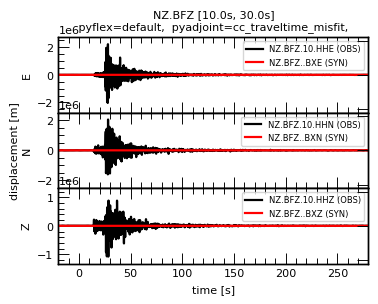

In [25]:
mgmt.plot(choice="wav", figsize=(4, 3))

/Users/Chow/Documents/academic/vuw/packages/pyatoa/pyatoa/visuals/map_maker.py:151: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  area_thresh=area_thresh, ax=ax,


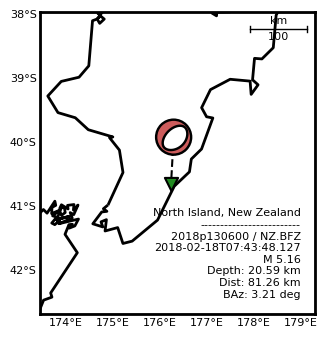

In [26]:
mgmt.plot(choice="map", figsize=(4, 4))

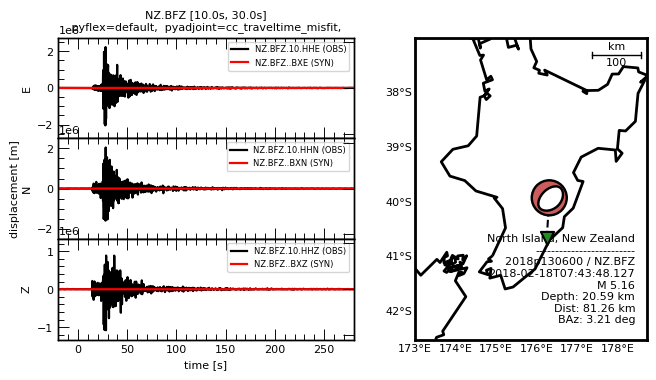

In [27]:
mgmt.plot(choice="both", corners={"lat_min": -42.5,
                                  "lat_max": -37.0,
                                  "lon_min": 173.0,
                                  "lon_max": 178.5},
          figsize=(8, 4)
         )

---
## Preprocessing

Preprocessing involves detrending, filtering, and instrument response removal for observed waveforms. Instrument response must be available in the `inv` attribute.  

Preprocessing parameters should be set in the `config` attribute. The relevant parameters are located in the `PROCESS` section of the `Config` string representation.

In [28]:
mgmt.inv[0][0][0].response

Channel Response
	From m/s (None) to count (None)
	Overall Sensitivity: 2.51658e+09 defined at 1.000 Hz
	3 stages:
		Stage 1: PolesZerosResponseStage from m/s to V, gain: 1500
		Stage 2: CoefficientsTypeResponseStage from V to count, gain: 1.67772e+06
		Stage 3: FIRResponseStage from count to count, gain: 1

In [29]:
mgmt.config

CONFIG
    iteration:               None
    step_count:              None
    event_id:                None
GATHER
    client:                  None
    start_pad:               20
    end_pad:                 500
    save_to_ds:              True
PROCESS
    min_period:              10.0
    max_period:              30.0
    filter_corners:          2.0
    unit_output:             DISP
    rotate_to_rtz:           False
    win_amp_ratio:           0.0
    synthetics_only:         False
LABELS
    component_list:          ['Z', 'N', 'E']
    observed_tag:            observed
    synthetic_tag:           synthetic
    paths:                   {'waveforms': [], 'synthetics': [], 'responses': []}
EXTERNAL
    pyflex_preset:           default
    adj_src_type:            cc_traveltime_misfit
    pyflex_config:           <pyflex.config.Config object at 0x12080c0b8>
    pyadjoint_config:        <pyadjoint.config.Config object at 0x11aa85048>

Pyatoa ships with a default preprocessing function, which involves tapering, response removal, and filtering.  
The `Stats and Status` section of the `Manager` string representation lets the user know if the waveforms have been preprocessed successfully. 

[2020-08-11 17:52:33] - pyatoa - INFO: preprocessing observation data
[2020-08-11 17:52:33] - pyatoa - INFO: adjusting taper to cover time offset
[2020-08-11 17:52:33] - pyatoa - DEBUG: remove response, units of DISP
[2020-08-11 17:52:33] - pyatoa - DEBUG: bandpass filter 10.0-30.0s w/ 2.0 corners
[2020-08-11 17:52:33] - pyatoa - INFO: preprocessing synthetic data
[2020-08-11 17:52:33] - pyatoa - INFO: adjusting taper to cover time offset
[2020-08-11 17:52:33] - pyatoa - DEBUG: bandpass filter 10.0-30.0s w/ 2.0 corners


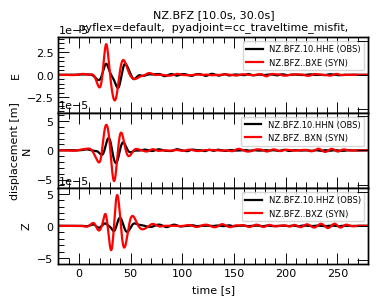

In [30]:
mgmt.preprocess()
mgmt.plot(choice="wav", figsize=(4, 3))

---
## Custom preprocessing functions

A custom preprocessing routine may be required. It is possible to substitute a user-defined preprocessing function using the `overwrite` argument in the `preprocess()` function.  

To use `overwrite`, the user must define a function with two mandatory arguments: `Manager` and `choice`. The `choice` argument allows different preprocessing steps for observed (obs) and synthetic (syn) data. The function must return an ObsPy `Stream` object.  


This functionality is illustrated below.

[2020-08-11 17:52:35] - pyatoa - INFO: standardizing streams
[2020-08-11 17:52:35] - pyatoa - DEBUG: zero pad NZ.BFZ.10.HHE (0, 0) samples
[2020-08-11 17:52:35] - pyatoa - DEBUG: new starttime NZ.BFZ.10.HHE: 2018-02-18T07:43:28.127644Z
[2020-08-11 17:52:35] - pyatoa - DEBUG: zero pad NZ.BFZ.10.HHN (0, 0) samples
[2020-08-11 17:52:35] - pyatoa - DEBUG: new starttime NZ.BFZ.10.HHN: 2018-02-18T07:43:28.127644Z
[2020-08-11 17:52:35] - pyatoa - DEBUG: zero pad NZ.BFZ.10.HHZ (0, 0) samples
[2020-08-11 17:52:35] - pyatoa - DEBUG: new starttime NZ.BFZ.10.HHZ: 2018-02-18T07:43:28.127644Z
[2020-08-11 17:52:35] - pyatoa - DEBUG: time offset is -20.0s
[2020-08-11 17:52:35] - pyatoa - INFO: preprocessing observation data
[2020-08-11 17:52:35] - pyatoa - INFO: preprocessing synthetic data


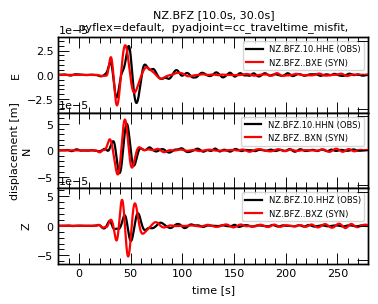

In [31]:
def custom_preprocessing(mgmt, choice):
    """
    This function performs a custom preprocessing for the Manager class.
    
    :type mgmt: pyatoa.core.manager.Manager
    :param mgmt: the Manager class, which contains standardized data
    :type choice: str
    :param choice: choice of output, either "obs" or "syn"
    :rtype: obspy.core.stream.Stream
    :return: A preprocessed ObsPy Stream object
    """
    if choice == "obs":
        st = mgmt.st_obs
    elif choice == "syn":
        st = mgmt.st_syn
        
    # The `choice` argument allows different preprocessing for `obs` and `syn`
    if choice == "obs":
        st.remove_response(inventory=mgmt.inv, 
                           output=mgmt.config.unit_output)
        
        # Here we add a random action to scale data
        for tr in st:
            tr.data *= 2

    # Access to Config parameters is still possible 
    st.filter("bandpass", freqmin=1/mgmt.config.max_period, 
              freqmax=1/mgmt.config.min_period)
    
    # MUST output a Stream
    return st

# Instantiate the Manager class
mgmt = Manager(config=cfg, inv=inv, event=event, st_obs=st_obs, st_syn=st_syn)

# Functions can be chained together to simplify workflow calls
mgmt.standardize().preprocess(overwrite=custom_preprocessing)
mgmt.plot(choice="wav", figsize=(4, 3))

----
## Time windowing using Pyflex

Time windows are selected based on an STA/LTA waveform derived using the synthetic stream, and internal rejection criteria defined by the FLEXWIN algorithm. Parameters used to define the internal rejection criteria are set in the Pyflex Config object. Here we use the default Pyflex parameters to select windows for our test data.  

Plotting the Manager shows the newly chosen time windows, rejected time windows and the reason for their rejection, annotations denoting the quality of each window, and the STA/LTA waveform and its accompanying water level.

[2020-08-11 17:52:37] - pyatoa - INFO: running Pyflex w/ map: default
[2020-08-11 17:52:37] - pyatoa - INFO: 1 window(s) selected for comp Z
[2020-08-11 17:52:37] - pyatoa - INFO: 1 window(s) selected for comp N
[2020-08-11 17:52:37] - pyatoa - INFO: 1 window(s) selected for comp E
[2020-08-11 17:52:37] - pyatoa - WARNING: Manager has no ASDFDataSet, cannot save windows
[2020-08-11 17:52:37] - pyatoa - INFO: 3 window(s) total found


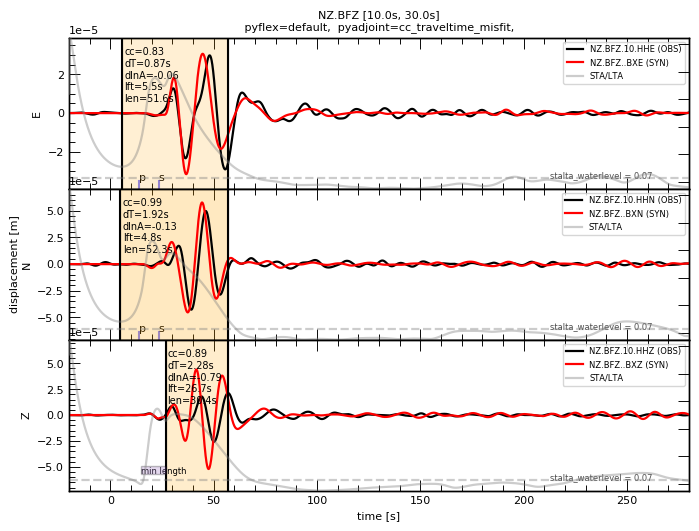

In [32]:
mgmt.window()
mgmt.plot(choice="wav")

We can see that 3 windows have been collected, one for each component. 
It is possible to access the individual `pyflex.Window` objects by querying the `Manager.windows` atrribute,
which is a dictionary containing lists of `Window` objects.

In [33]:
mgmt.windows

{'Z': [Window(left=1557, right=2569, center=2063, channel_id=NZ.BFZ.10.HHZ, max_cc_value=0.8923893777352603, cc_shift=76, dlnA=-0.792290714544218)],
 'N': [Window(left=827, right=2569, center=1698, channel_id=NZ.BFZ.10.HHN, max_cc_value=0.9873360888477792, cc_shift=64, dlnA=-0.13343443319138773)],
 'E': [Window(left=849, right=2569, center=1709, channel_id=NZ.BFZ.10.HHE, max_cc_value=0.8272815676869814, cc_shift=29, dlnA=-0.06282611168508791)]}

---
## Misfit measurement & adjoint sources with Pyadjoint

Within each time window, we can evaluate the adjoint source. For each component, a misfit value $\chi$ is calculated, which can be collected and summed with misfit values from other components, stations and source-receiver pairs, to provide an evaluation of an objective function for a seismic inversion.

The adjoint source type is defined by the Config parameter `adj_src_type`, and the configuration parameters of Pyadjoint are set in the Config parameter `pyadjoint_config`

Plotting the Manager at this stage sees inclusion of adjoint source traces, as well as $\chi$ values for each component.

[2020-08-11 17:52:39] - pyatoa - DEBUG: running Pyadjoint w/ type: cc_traveltime_misfit
[2020-08-11 17:52:39] - pyatoa - INFO: 2.808 misfit for comp Z
[2020-08-11 17:52:39] - pyatoa - INFO: 1.786 misfit for comp N
[2020-08-11 17:52:39] - pyatoa - INFO: 0.179 misfit for comp E
[2020-08-11 17:52:39] - pyatoa - WARNING: Manager has no ASDFDataSet, cannot save adjoint sources
[2020-08-11 17:52:39] - pyatoa - INFO: total misfit 4.774


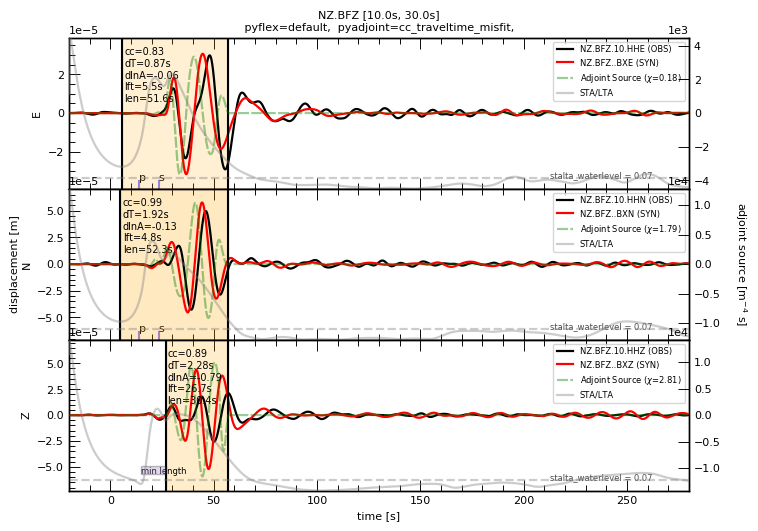

In [34]:
mgmt.measure()
mgmt.plot(choice="wav")

As with the windows, the resultant `Pyadjoint.AdjointSource` objects are stored in a dictionary in the Manager under the `adjsrcs` attribute. 

In [35]:
mgmt.adjsrcs

{'Z': <pyadjoint.adjoint_source.AdjointSource at 0x11aa0b4a8>,
 'N': <pyadjoint.adjoint_source.AdjointSource at 0x11e2c23c8>,
 'E': <pyadjoint.adjoint_source.AdjointSource at 0x11e2c2ba8>}

In [36]:
vars(mgmt.adjsrcs["Z"])

{'adj_src_type': 'cc_traveltime_misfit',
 'adj_src_name': 'Cross Correlation Traveltime Misfit',
 'misfit': 2.80845,
 'dt': 0.03,
 'min_period': 10.0,
 'max_period': 30.0,
 'component': 'HHZ',
 'network': 'NZ',
 'station': 'BFZ',
 'location': '10',
 'starttime': 2018-02-18T07:43:28.127644Z,
 'adjoint_source': array([ 0.,  0.,  0., ...,  0.,  0.,  0.])}

The `measure()` function is the final step in the Pyatoa internal workflow. What to do with this processed data is covered in other sections.  A summary of the workflow, and the internal stats of the `Manager` can be accessed through the Manager.  

In [37]:
mgmt

Manager Data
    dataset   [ds]:        None
    quakeml   [event]:     smi:nz.org.geonet/2018p130600
    station   [inv]:       NZ.BFZ
    observed  [st_obs]:    3
    synthetic [st_syn]:    3
Stats and Status
    half_dur:              0
    time_offset_sec:       -20.0
    standardized:          True
    obs_filtered:          True
    syn_filtered:          True
    nwin (windows):        3
    misfit (adjsrcs):      4.77E+00

In [38]:
mgmt.stats

{'dataset_id': None,
 'event_id': smi:nz.org.geonet/2018p130600,
 'inv_name': 'NZ.BFZ',
 'nwin': 3,
 'len_obs': 3,
 'len_syn': 3,
 'misfit': 4.773751366563984,
 'half_dur': 0,
 'time_offset_sec': -20.0,
 'standardized': True,
 'obs_filtered': True,
 'syn_filtered': True}

---
## The flow function

The `Manager.flow()` is a convenient function that calls each Manager function consecutively. If a `Manager` is included into a larger workflow tool, this makes running its internal workflow more concise. The flow takes key word arguments corresponding to optional arguments accepted by each of its workflow functions.

```python
# The flow function is equivalent to chaining the four main functions
mgmt.flow() == mgmt.standardize().preprocess().window().measure()
```

[2020-08-11 17:52:41] - pyatoa - INFO: standardizing streams
[2020-08-11 17:52:41] - pyatoa - DEBUG: zero pad NZ.BFZ.10.HHE (0, 0) samples
[2020-08-11 17:52:41] - pyatoa - DEBUG: new starttime NZ.BFZ.10.HHE: 2018-02-18T07:43:28.127644Z
[2020-08-11 17:52:41] - pyatoa - DEBUG: zero pad NZ.BFZ.10.HHN (0, 0) samples
[2020-08-11 17:52:41] - pyatoa - DEBUG: new starttime NZ.BFZ.10.HHN: 2018-02-18T07:43:28.127644Z
[2020-08-11 17:52:41] - pyatoa - DEBUG: zero pad NZ.BFZ.10.HHZ (0, 0) samples
[2020-08-11 17:52:41] - pyatoa - DEBUG: new starttime NZ.BFZ.10.HHZ: 2018-02-18T07:43:28.127644Z
[2020-08-11 17:52:41] - pyatoa - DEBUG: time offset is -20.0s
[2020-08-11 17:52:41] - pyatoa - INFO: preprocessing observation data
[2020-08-11 17:52:41] - pyatoa - INFO: adjusting taper to cover time offset
[2020-08-11 17:52:42] - pyatoa - DEBUG: remove response, units of DISP
[2020-08-11 17:52:42] - pyatoa - DEBUG: bandpass filter 10.0-30.0s w/ 2.0 corners
[2020-08-11 17:52:42] - pyatoa - INFO: preprocessing 

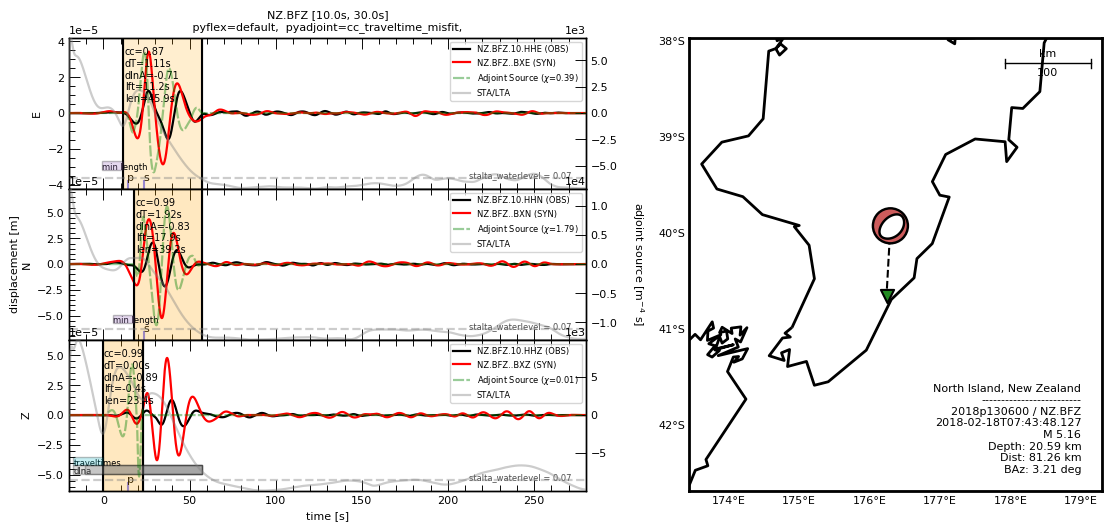

In [39]:
mgmt = Manager(config=cfg, inv=inv, event=event, st_obs=st_obs, st_syn=st_syn)
mgmt.flow()
mgmt.plot()